# Multi-Objective Bayesian Optimization for SparseGatedNet Mass Spectrometry Model

This notebook implements multi-objective Bayesian optimization using Ax and BoTorch for hyperparameter tuning of a SparseGatedNet model for mass spectrometry prediction.

## Mathematical Framework

### Multi-Objective Optimization Problem

We solve the multi-objective optimization problem:

$$\mathbf{x}^* = \arg\max_{\mathbf{x} \in \mathcal{X}} [f_1(\mathbf{x}), -f_2(\mathbf{x})]$$

Where:
- $f_1(\mathbf{x})$ = Cosine similarity (maximize)
- $f_2(\mathbf{x})$ = RMSE (minimize, hence negated)
- $\mathcal{X}$ = Hyperparameter search space

### SparseGatedNet Architecture

SparseGatedNet uses learned gating to handle extreme sparsity (74.4% zeros) in mass spectra:

$$g = \sigma(W_{gate} \cdot h_{gate}(x)) / T$$
$$y = g \odot f_{dense}(x) + (1-g) \odot f_{sparse}(x)$$

### Batch Acquisition Function

We use qNEHVI (quasi-Noisy Expected Hypervolume Improvement) for batch acquisition:

$$\alpha_{qNEHVI}(\mathbf{X}) = \mathbb{E}[HV(\mathcal{P} \cup f(\mathbf{X})) - HV(\mathcal{P})]$$

Where $\mathcal{P}$ is the current Pareto frontier and $HV$ is the hypervolume indicator.

## 1. Environment Setup and Thread Control

Set environment variables before importing numerical libraries to prevent thread oversubscription.

In [1]:
# Prevent thread oversubscription for parallel processing
import os
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("VECLIB_MAXIMUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

import json
import pickle
import warnings
import logging
from typing import Dict, Any, Tuple, List, Optional, Union
from datetime import datetime
from dataclasses import dataclass, field
from pathlib import Path
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr, spearmanr
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

# Force CPU usage for torch (MPS doesn't work with BoTorch)
torch.set_default_device("cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(-1)  # Disable CUDA
    
# Ax and BoTorch imports
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Generators
from ax.core.optimization_config import MultiObjectiveOptimizationConfig
from ax.core.objective import MultiObjective, Objective
from ax.core.metric import Metric
from ax.core.outcome_constraint import ObjectiveThreshold
from ax.core.types import ComparisonOp

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

logger.info(f"Environment setup complete. CPU count: {os.cpu_count()}")
logger.info(f"Torch device: CPU (required for BoTorch)")
logger.info("BoTorch will run on CPU (required for stability)")

[WARNING 08-25 16:53:49] ax.service.utils.with_db_settings_base: Ax currently requires a sqlalchemy version below 2.0. This will be addressed in a future release. Disabling SQL storage in Ax for now, if you would like to use SQL storage please install Ax with mysql extras via `pip install ax-platform[mysql]`.
/var/folders/_g/yv_ycc0s11z1x8zk__56l6r80000gn/T/ipykernel_39140/1739296870.py:46: DeprecationWarning: Please import from 'ax.generation_strategy.generation_strategy' instead of 'ax.modelbridge.generation_strategy'. The latter is deprecated and will be removed in a future release.
  from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
2025-08-25 16:53:49,130 - INFO - Environment setup complete. CPU count: 16
2025-08-25 16:53:49,131 - INFO - Torch device: CPU (required for BoTorch)
2025-08-25 16:53:49,132 - INFO - BoTorch will run on CPU (required for stability)


## 2. Configuration Dataclass

Using dataclasses for clean configuration management following SOLID principles.

In [2]:
@dataclass
class OptimizationConfig:
    """Configuration for Bayesian optimization."""
    # Data paths
    results_dir: Path = Path('../data/results')
    models_dir: Path = Path('../models/bayesian_sparse_gated')
    input_type: str = 'hpj'
    use_selected_data: bool = False
    
    # Data processing
    transform_sqrt: bool = True
    validation_split: float = 0.2
    random_state: int = 42
    target_sparsity: float = 0.744  # Known sparsity in target spectra
    
    # Optimization settings
    n_iterations: int = 50
    n_initial_points: int = 14  # Sobol initialization
    batch_size: int = 8  # Parallel evaluations (smaller for NN)
    
    # Speed optimization
    row_subsample_frac: float = 0.3  # Subsample for faster evaluation
    max_bins_eval: int = 512  # Limit bins for evaluation
    max_epochs_eval: int = 30  # Limit epochs during optimization
    max_epochs_final: int = 100  # More epochs for final training
    
    # Multi-objective settings
    objectives: List[str] = field(default_factory=lambda: ['cosine_similarity', 'rmse'])
    minimize: List[bool] = field(default_factory=lambda: [False, True])
    
    # Early stopping
    early_stopping_patience: int = 10
    
    def __post_init__(self):
        self.models_dir.mkdir(parents=True, exist_ok=True)
        
    @property
    def data_dir(self) -> Path:
        subdir = 'selected' if self.use_selected_data else 'full_featurised'
        return self.results_dir / self.input_type / subdir
    
    def get_data_paths(self) -> Dict[str, Path]:
        return {
            'train': self.data_dir / 'train_data.jsonl',
            'val': self.data_dir / 'val_data.jsonl',
            'test': self.data_dir / 'test_data.jsonl'
        }

config = OptimizationConfig()

## 3. Data Loading and Preprocessing

Efficient data loading with vectorized operations and proper scaler management.

In [3]:
class DataLoader:
    """Handles data loading and preprocessing."""
    
    @staticmethod
    def load_jsonl(filepath: Path) -> Tuple[List[str], np.ndarray, np.ndarray]:
        """Load data from JSONL file."""
        if not filepath.exists():
            raise FileNotFoundError(f"File not found: {filepath}")
        
        data = []
        with open(filepath, 'r') as f:
            for line in tqdm(f, desc=f"Loading {filepath.name}"):
                try:
                    record = json.loads(line)
                    if all(k in record for k in ['smiles', 'features', 'target']):
                        data.append(record)
                except json.JSONDecodeError:
                    continue
        
        if not data:
            raise ValueError(f"No valid data in {filepath}")
        
        smiles = [d['smiles'] for d in data]
        features = np.array([d['features'] for d in data])
        targets = np.array([d['target'] for d in data])
        
        logger.info(f"Loaded {len(smiles)} samples from {filepath.name}")
        return smiles, features, targets
    
    @staticmethod
    def prepare_data(config: OptimizationConfig) -> Dict[str, Any]:
        """Load and prepare all data using existing train/val/test splits."""
        paths = config.get_data_paths()
        
        # Load all three splits
        train_smiles, X_train, y_train = DataLoader.load_jsonl(paths['train'])
        val_smiles, X_val, y_val = DataLoader.load_jsonl(paths['val'])
        test_smiles, X_test, y_test = DataLoader.load_jsonl(paths['test'])
        
        # Apply transformation
        if config.transform_sqrt:
            y_train = np.sqrt(np.maximum(y_train, 0))
            y_val = np.sqrt(np.maximum(y_val, 0))
            y_test = np.sqrt(np.maximum(y_test, 0))
        
        # Create subsampled indices for fast evaluation during optimization
        rng = np.random.RandomState(config.random_state)
        n_subsample = int(len(X_val) * config.row_subsample_frac)
        row_idx = rng.choice(len(X_val), n_subsample, replace=False)
        bin_idx = slice(None, min(config.max_bins_eval, y_val.shape[1]))
        
        # Scale features for optimization - fit on train, apply to val
        opt_scaler = StandardScaler()
        X_train_scaled = opt_scaler.fit_transform(X_train)
        X_val_scaled = opt_scaler.transform(X_val)
        
        # Subsampled validation data for fast evaluation
        X_val_sub = X_val_scaled[row_idx]
        y_val_sub = y_val[row_idx][:, bin_idx]
        
        # Also subsample training for faster optimization
        n_train_sub = int(len(X_train) * 0.5)  # Use 50% of training data during optimization
        train_row_idx = rng.choice(len(X_train), n_train_sub, replace=False)
        X_train_sub = X_train_scaled[train_row_idx]
        y_train_sub = y_train[train_row_idx][:, bin_idx]
        
        # Separate scaler for final training (refit on full train for final model)
        final_scaler = StandardScaler()
        X_train_final = final_scaler.fit_transform(X_train)
        X_test_scaled = final_scaler.transform(X_test)
        
        return {
            'X_opt_train': X_train_scaled,  # Full training for optimization
            'X_opt_train_sub': X_train_sub,  # Subsampled training for fast eval
            'y_opt_train_sub': y_train_sub,  # Subsampled targets
            'X_opt_val': X_val_scaled,      # Full validation
            'y_opt_train': y_train,
            'y_opt_val': y_val,
            'X_opt_val_sub': X_val_sub,     # Subsampled validation
            'y_opt_val_sub': y_val_sub,
            'X_train': X_train_final,       # For final training
            'X_test': X_test_scaled,        # For final evaluation
            'y_train': y_train,
            'y_val': y_val,                 # Keep original val
            'y_test': y_test,
            'opt_scaler': opt_scaler,
            'final_scaler': final_scaler,
            'bin_idx': bin_idx,
            'input_dim': X_train.shape[1],
            'output_dim': y_train.shape[1]
        }

# Load data
data = DataLoader.prepare_data(config)
logger.info(f"Data shapes - Train: {data['X_opt_train'].shape}, Val: {data['X_opt_val'].shape}, Test: {data['X_test'].shape}")
logger.info(f"Subsampled train for fast eval: {data['X_opt_train_sub'].shape}")
logger.info(f"Subsampled val for fast eval: {data['X_opt_val_sub'].shape}")

Loading train_data.jsonl: 0it [00:00, ?it/s]

2025-08-25 16:53:53,413 - INFO - Loaded 2176 samples from train_data.jsonl


Loading val_data.jsonl: 0it [00:00, ?it/s]

2025-08-25 16:53:54,055 - INFO - Loaded 272 samples from val_data.jsonl


Loading test_data.jsonl: 0it [00:00, ?it/s]

2025-08-25 16:53:54,531 - INFO - Loaded 272 samples from test_data.jsonl
2025-08-25 16:53:54,882 - INFO - Data shapes - Train: (2176, 7137), Val: (272, 7137), Test: (272, 7137)
2025-08-25 16:53:54,884 - INFO - Subsampled train for fast eval: (1088, 7137)
2025-08-25 16:53:54,884 - INFO - Subsampled val for fast eval: (81, 7137)


## 4. Metrics Computation and Neural Network Components

Vectorized metrics computation and neural network building blocks.

In [4]:
class MetricsComputer:
    """Compute evaluation metrics."""
    
    @staticmethod
    def cosine_similarity(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """Compute mean cosine similarity."""
        # Vectorized cosine similarity
        dot_product = np.sum(y_true * y_pred, axis=1)
        norm_true = np.linalg.norm(y_true, axis=1)
        norm_pred = np.linalg.norm(y_pred, axis=1)
        
        # Avoid division by zero
        valid_mask = (norm_true > 0) & (norm_pred > 0)
        similarities = np.zeros(len(y_true))
        similarities[valid_mask] = dot_product[valid_mask] / (norm_true[valid_mask] * norm_pred[valid_mask])
        
        return float(np.mean(similarities))
    
    @staticmethod
    def compute_all_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
        """Compute all evaluation metrics."""
        return {
            'cosine_similarity': MetricsComputer.cosine_similarity(y_true, y_pred),
            'rmse': float(np.sqrt(mean_squared_error(y_true, y_pred))),
            'mae': float(mean_absolute_error(y_true, y_pred)),
            'r2': float(r2_score(y_true, y_pred))
        }

# Define activation function mapping
ACTIVATION_FUNCTIONS = {
    'relu': nn.ReLU,
    'elu': nn.ELU,
    'gelu': nn.GELU,
    'selu': nn.SELU,
    'leaky_relu': lambda: nn.LeakyReLU(0.1)
}

# Loss functions for SparseGatedNet
def cosine_loss(pred, true, eps=1e-8):
    """Cosine distance loss."""
    num = (pred * true).sum(1)
    den = torch.norm(pred, 2, 1) * torch.norm(true, 2, 1) + eps
    return 1.0 - (num / den).mean()

def sparsity_loss(pred):
    """L1 regularization to encourage sparsity."""
    return pred.abs().mean()

def sparsity_aware_loss(pred, target, zero_weight=0.1, nonzero_weight=1.0):
    """Loss that explicitly handles sparse targets."""
    zero_mask = target < 0.01  # Consider very small values as zeros
    nonzero_mask = ~zero_mask
    
    # Separate losses for zero and non-zero regions
    if zero_mask.any():
        zero_loss = zero_weight * F.mse_loss(
            pred[zero_mask], target[zero_mask], reduction='mean'
        )
    else:
        zero_loss = torch.tensor(0.0, device=pred.device)
    
    if nonzero_mask.any():
        nonzero_loss = nonzero_weight * F.mse_loss(
            pred[nonzero_mask], target[nonzero_mask], reduction='mean'
        )
    else:
        nonzero_loss = torch.tensor(0.0, device=pred.device)
    
    # Weight by prevalence
    n_zero = zero_mask.sum().float()
    n_nonzero = nonzero_mask.sum().float()
    total = n_zero + n_nonzero
    
    if total > 0:
        return (n_zero / total) * zero_loss + (n_nonzero / total) * nonzero_loss
    else:
        return torch.tensor(0.0, device=pred.device)

## 5. SparseGatedNet Architecture

Define the SparseGatedNet architecture with learned gating for sparse/dense pathways.

### Architecture Components:

1. **Sparse Gating Layer**: Routes information through sparse or dense pathways
   $$g = \sigma(W_{gate} \cdot \text{GateNet}(x)) / T$$

2. **Hierarchical Gated Layers**: Multiple levels of gating
   $$h_i = \text{GatedLayer}_i(h_{i-1})$$

3. **Output Gating**: Final sparse/dense decision
   $$y_{final} = g_{out} \odot y_{dense} + (1-g_{out}) \odot \alpha \cdot y_{sparse}$$

In [5]:
class SparseGatingLayer(nn.Module):
    """Gating layer for sparse predictions."""
    def __init__(self, input_dim, gate_hidden, temperature=1.0, activation='relu', use_residual=False):
        super().__init__()
        self.temperature = temperature
        self.use_residual = use_residual
        
        activation_fn = ACTIVATION_FUNCTIONS[activation]
        
        self.gate_net = nn.Sequential(
            nn.Linear(input_dim, gate_hidden),
            activation_fn(),
            nn.Linear(gate_hidden, input_dim),
            nn.Sigmoid()
        )
        
        self.sparse_path = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.BatchNorm1d(input_dim),
            activation_fn(),
            nn.Dropout(0.1)
        )
        
        self.dense_path = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.BatchNorm1d(input_dim),
            activation_fn(),
            nn.Dropout(0.1)
        )
    
    def forward(self, x):
        gates = self.gate_net(x) / self.temperature
        sparse_out = self.sparse_path(x)
        dense_out = self.dense_path(x)
        
        output = gates * dense_out + (1 - gates) * sparse_out
        
        if self.use_residual:
            output = output + x  # Residual connection
        
        return output, gates

class SparseGatedNet(nn.Module):
    """SparseGatedNet with configurable architecture."""
    def __init__(self, input_dim, output_dim, config):
        super().__init__()
        
        num_layers = config['num_layers']
        hidden_size = config['hidden_size']
        gate_hidden = config['gate_hidden']
        temperature = config.get('gate_temperature', 1.0)
        sparsity_threshold = config.get('sparsity_threshold', 0.01)
        dropout = config.get('dropout', 0.1)
        activation = config.get('activation', 'relu')
        use_batch_norm = config.get('use_batch_norm', True)
        use_residual = config.get('use_residual', False)
        
        activation_fn = ACTIVATION_FUNCTIONS[activation]
        
        # Initial projection
        initial_layers = []
        initial_layers.append(nn.Linear(input_dim, hidden_size))
        if use_batch_norm:
            initial_layers.append(nn.BatchNorm1d(hidden_size))
        initial_layers.append(activation_fn())
        initial_layers.append(nn.Dropout(dropout))
        
        self.input_proj = nn.Sequential(*initial_layers)
        
        # Build hierarchical gated layers
        self.gated_layers = nn.ModuleList()
        self.transitions = nn.ModuleList()
        
        current_dim = hidden_size
        for i in range(num_layers):
            # Gated layer
            self.gated_layers.append(
                SparseGatingLayer(current_dim, gate_hidden, temperature, activation, use_residual)
            )
            
            # Transition to next dimension (if not last layer)
            if i < num_layers - 1:
                next_dim = hidden_size if i < num_layers - 2 else hidden_size
                transition_layers = []
                transition_layers.append(nn.Linear(current_dim, next_dim))
                if use_batch_norm:
                    transition_layers.append(nn.BatchNorm1d(next_dim))
                transition_layers.append(activation_fn())
                transition_layers.append(nn.Dropout(dropout))
                
                self.transitions.append(nn.Sequential(*transition_layers))
                current_dim = next_dim
        
        # Output projections for sparse and dense predictions
        self.output_sparse = nn.Sequential(
            nn.Linear(current_dim, output_dim),
            nn.ReLU()  # Non-negative outputs
        )
        
        self.output_dense = nn.Sequential(
            nn.Linear(current_dim, output_dim),
            nn.ReLU()  # Non-negative outputs
        )
        
        # Output gating mechanism
        self.output_gate = nn.Sequential(
            nn.Linear(current_dim, output_dim),
            nn.Sigmoid()
        )
        
        # Learnable sparsity scaling factor
        self.sparsity_scale = nn.Parameter(torch.tensor(0.1))
        self.sparsity_threshold = sparsity_threshold
    
    def forward(self, x):
        x = self.input_proj(x)
        
        # Pass through gated layers
        gate_activations = []
        for i, gated_layer in enumerate(self.gated_layers):
            x, gates = gated_layer(x)
            gate_activations.append(gates.mean())  # Track gating activity
            
            # Apply transition if not last layer
            if i < len(self.transitions):
                x = self.transitions[i](x)
        
        # Generate sparse and dense predictions
        sparse_pred = self.output_sparse(x)
        dense_pred = self.output_dense(x)
        output_gates = self.output_gate(x)
        
        # Apply sparsity-aware gating
        sparse_pred_scaled = sparse_pred * torch.abs(self.sparsity_scale)
        
        # Combine predictions
        output = output_gates * dense_pred + (1 - output_gates) * sparse_pred_scaled
        
        # Apply soft thresholding for extreme sparsity
        output = F.relu(output - self.sparsity_threshold) + self.sparsity_threshold * torch.sigmoid(
            (output - self.sparsity_threshold) * 100
        )
        
        return output

## 6. Search Space Definition

Define the hyperparameter search space for SparseGatedNet.

### Search Space Design

We define a comprehensive search space $\mathcal{X}$ covering:

- **Architecture parameters**: layers, hidden sizes, gating parameters
- **Training parameters**: learning rate, batch size, optimizer
- **Regularization**: dropout, weight decay
- **Loss weights**: cosine, MSE, sparsity, zero/non-zero weights

In [6]:
def create_search_space() -> List[Dict[str, Any]]:
    """Create Ax search space for SparseGatedNet."""
    return [
        # Architecture parameters
        {
            "name": "num_layers",
            "type": "range",
            "bounds": [1, 5],
            "value_type": "int"
        },
        {
            "name": "hidden_size",
            "type": "range",
            "bounds": [64, 512],
            "value_type": "int"
        },
        {
            "name": "gate_hidden",
            "type": "range",
            "bounds": [16, 128],
            "value_type": "int"
        },
        {
            "name": "gate_temperature",
            "type": "range",
            "bounds": [0.1, 5.0],
            "value_type": "float"
        },
        {
            "name": "sparsity_threshold",
            "type": "range",
            "bounds": [0.0001, 0.1],
            "value_type": "float",
            "log_scale": True
        },
        {
            "name": "activation",
            "type": "choice",
            "values": ["relu", "elu", "gelu", "selu", "leaky_relu"],
            "value_type": "str"
        },
        # Training parameters
        {
            "name": "learning_rate",
            "type": "range",
            "bounds": [0.00001, 0.01],
            "value_type": "float",
            "log_scale": True
        },
        {
            "name": "batch_size",
            "type": "choice",
            "values": [16, 32, 64, 128],
            "value_type": "int"
        },
        {
            "name": "optimizer",
            "type": "choice",
            "values": ["adam", "adamw", "sgd"],
            "value_type": "str"
        },
        # Regularization
        {
            "name": "dropout",
            "type": "range",
            "bounds": [0.0, 0.5],
            "value_type": "float"
        },
        {
            "name": "weight_decay",
            "type": "range",
            "bounds": [0.0, 0.01],
            "value_type": "float"
        },
        # Loss weights
        {
            "name": "weight_cosine",
            "type": "range",
            "bounds": [0.0, 5.0],
            "value_type": "float"
        },
        {
            "name": "weight_mse",
            "type": "range",
            "bounds": [0.1, 2.0],
            "value_type": "float"
        },
        {
            "name": "weight_sparsity",
            "type": "range",
            "bounds": [0.000001, 0.01],
            "value_type": "float",
            "log_scale": True
        },
        {
            "name": "zero_weight",
            "type": "range",
            "bounds": [0.01, 0.5],
            "value_type": "float"
        },
        {
            "name": "nonzero_weight",
            "type": "range",
            "bounds": [0.5, 2.0],
            "value_type": "float"
        },
        # Additional options
        {
            "name": "use_batch_norm",
            "type": "choice",
            "values": [True, False],
            "value_type": "bool"
        },
        {
            "name": "use_residual",
            "type": "choice",
            "values": [True, False],
            "value_type": "bool"
        }
    ]

## 7. Evaluation Function

The evaluation function trains a SparseGatedNet model and returns multiple objectives.
Uses subsampled data for faster evaluation during optimization.

In [7]:
def train_and_evaluate_nn(parameters: Dict[str, Any], data: Dict[str, np.ndarray], 
                          config: OptimizationConfig, use_subsample: bool = True) -> Dict[str, Tuple[float, float]]:
    """Train and evaluate SparseGatedNet with given parameters.
    
    Args:
        parameters: Hyperparameters to evaluate
        data: Data dictionary
        config: Optimization configuration
        use_subsample: Whether to use subsampled data for faster evaluation
    
    Returns:
        dict with cosine_similarity and rmse (mean, sem) tuples
    """
    # Build model configuration
    model_config = {
        'num_layers': parameters['num_layers'],
        'hidden_size': parameters['hidden_size'],
        'gate_hidden': parameters['gate_hidden'],
        'gate_temperature': parameters['gate_temperature'],
        'sparsity_threshold': parameters['sparsity_threshold'],
        'activation': parameters['activation'],
        'dropout': parameters['dropout'],
        'use_batch_norm': parameters['use_batch_norm'],
        'use_residual': parameters['use_residual']
    }
    
    # Select appropriate data
    if use_subsample:
        X_train = data['X_opt_train_sub']
        y_train = data['y_opt_train_sub']
        X_val = data['X_opt_val_sub']
        y_val = data['y_opt_val_sub']
        output_dim = y_train.shape[1]
    else:
        X_train = data['X_opt_train']
        y_train = data['y_opt_train']
        X_val = data['X_opt_val']
        y_val = data['y_opt_val']
        output_dim = data['output_dim']
    
    # Create data loaders
    train_dataset = TensorDataset(
        torch.from_numpy(X_train).float(),
        torch.from_numpy(y_train).float()
    )
    val_dataset = TensorDataset(
        torch.from_numpy(X_val).float(),
        torch.from_numpy(y_val).float()
    )
    
    batch_size = min(parameters['batch_size'], len(train_dataset) // 2)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False
    )
    
    # Initialize model
    model = SparseGatedNet(data['input_dim'], output_dim, model_config)
    
    # Create optimizer
    if parameters['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=parameters['learning_rate'],
            weight_decay=parameters['weight_decay']
        )
    elif parameters['optimizer'] == 'adamw':
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=parameters['learning_rate'],
            weight_decay=parameters['weight_decay']
        )
    else:  # sgd
        optimizer = torch.optim.SGD(
            model.parameters(), 
            lr=parameters['learning_rate'],
            weight_decay=parameters['weight_decay'],
            momentum=0.9
        )
    
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Training loop
    best_val_loss = float('inf')
    patience_counter = 0
    max_epochs = config.max_epochs_eval if use_subsample else config.max_epochs_final
    
    for epoch in range(max_epochs):
        # Training
        model.train()
        train_losses = []
        
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(x_batch)
            
            # Combined loss
            loss_intensity = sparsity_aware_loss(
                predictions, y_batch,
                parameters['zero_weight'], parameters['nonzero_weight']
            )
            loss_cosine = cosine_loss(predictions, y_batch)
            loss_sparse = sparsity_loss(predictions)
            
            total_loss = (
                parameters['weight_mse'] * loss_intensity +
                parameters['weight_cosine'] * loss_cosine +
                parameters['weight_sparsity'] * loss_sparse
            )
            
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_losses.append(total_loss.item())
        
        # Validation
        model.eval()
        val_losses = []
        
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                predictions = model(x_batch)
                
                loss_intensity = sparsity_aware_loss(
                    predictions, y_batch,
                    parameters['zero_weight'], parameters['nonzero_weight']
                )
                loss_cosine = cosine_loss(predictions, y_batch)
                loss_sparse = sparsity_loss(predictions)
                
                total_loss = (
                    parameters['weight_mse'] * loss_intensity +
                    parameters['weight_cosine'] * loss_cosine +
                    parameters['weight_sparsity'] * loss_sparse
                )
                val_losses.append(total_loss.item())
        
        avg_val_loss = np.mean(val_losses)
        scheduler.step(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config.early_stopping_patience:
                break
    
    # Final evaluation
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.from_numpy(X_val).float()).numpy()
        y_pred = np.maximum(y_pred, 0)
    
    # Compute metrics
    metrics = MetricsComputer.compute_all_metrics(y_val, y_pred)
    
    return {
        'cosine_similarity': (metrics['cosine_similarity'], 0.0),  # (mean, sem)
        'rmse': (metrics['rmse'], 0.0)
    }

# Helper function for parallel evaluation (no AxClient calls)
def _run_nn_eval(params: Dict[str, Any]) -> Dict[str, Tuple[float, float]]:
    """Wrapper for parallel evaluation - compute only, no AxClient calls."""
    return train_and_evaluate_nn(params, data, config, use_subsample=True)

## 8. Multi-Objective Bayesian Optimization Setup

### Optimization Strategy

1. **Initialization Phase**: Use Sobol sequence for space-filling design
2. **Threshold Setting**: After initialization, set objective thresholds based on observed data
3. **Bayesian Phase**: Use NEHVI for multi-objective acquisition
4. **Parallel Batch Evaluation**: Evaluate multiple candidates in parallel

In [8]:
# Initialize Ax client
ax_client = AxClient(verbose_logging=False)

# Create experiment with multi-objective optimization
ax_client.create_experiment(
    name="sparsegatednet_multi_objective_optimization",
    parameters=create_search_space(),
    objectives={
        "cosine_similarity": ObjectiveProperties(minimize=False),
        "rmse": ObjectiveProperties(minimize=True)
    },
    overwrite_existing_experiment=True,
    immutable_search_space_and_opt_config=False,  # Allow config updates
)

# Define generation strategy for efficient optimization
gs = GenerationStrategy(
    steps=[
        # Sobol initialization for space exploration
        GenerationStep(
            model=Generators.SOBOL,
            num_trials=config.n_initial_points,
            min_trials_observed=config.n_initial_points
        ),
        # Multi-objective Bayesian optimization
        GenerationStep(
            model=Generators.BOTORCH_MODULAR,
            num_trials=-1,  # No limit
        )
    ]
)

ax_client._generation_strategy = gs

logger.info("Starting multi-objective Bayesian optimization for SparseGatedNet")
logger.info(f"Objectives: maximize cosine_similarity, minimize RMSE")
logger.info(f"Total trials: {config.n_iterations}, Batch size: {config.batch_size}")
logger.info(f"Parallel workers: {min(config.batch_size, os.cpu_count())}")

[WARNING 08-25 16:53:55] ax.service.utils.instantiation: Objective thresholds were not set. They will be selected using a heuristic, but should be specified on the objective for best performance.
[INFO 08-25 16:53:55] ax.generation_strategy.dispatch_utils: Using Generators.BOTORCH_MODULAR since there are more ordered parameters than there are categories for the unordered categorical parameters.
[INFO 08-25 16:53:55] ax.generation_strategy.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+BoTorch', steps=[Sobol for 36 trials, BoTorch for subsequent trials]). Iterations after 36 will take longer to generate due to model-fitting.
2025-08-25 16:53:55,466 - INFO - Starting multi-objective Bayesian optimization for SparseGatedNet
2025-08-25 16:53:55,473 - INFO - Objectives: maximize cosine_similarity, minimize RMSE
2025-08-25 16:53:55,481 - INFO - Total trials: 50, Batch size: 8
2025-08-25 16:53:55,500 - INFO - Parallel workers: 8


## 9. Optimization Loop - Phase 1: Sobol Initialization

Run Sobol initialization with parallel batch evaluation to explore the space.

In [9]:
# Storage for results
trials_data = []
best_cosine = -np.inf
best_rmse = np.inf

# Start optimization timer
optimization_start_time = time.time()

# Progress bar
pbar = tqdm(total=config.n_iterations, desc="Optimization Progress")

# Phase 1: Sobol initialization with parallel evaluation
logger.info("Phase 1: Sobol initialization with parallel evaluation")
trial_index = 0

while trial_index < config.n_initial_points:
    # Generate batch of trials
    batch_size = min(config.batch_size, config.n_initial_points - trial_index)
    
    batch_trials = []
    for _ in range(batch_size):
        parameters, trial_id = ax_client.get_next_trial()
        batch_trials.append((parameters, trial_id))
    
    # Extract parameters for parallel evaluation
    params_list = [params for params, _ in batch_trials]
    
    # Run evaluations in parallel
    raw_list = Parallel(
        n_jobs=min(config.batch_size, os.cpu_count()),
        backend="loky",
        prefer="processes"
    )(delayed(_run_nn_eval)(p) for p in params_list)
    
    # Log results back to Ax sequentially
    for (parameters, trial_id), raw_data in zip(batch_trials, raw_list):
        try:
            # Complete trial
            ax_client.complete_trial(trial_index=trial_id, raw_data=raw_data)
            
            # Extract metrics
            cosine_sim = raw_data['cosine_similarity'][0]
            rmse = raw_data['rmse'][0]
            
            # Track results
            trial_data = {
                'trial_id': trial_id,
                'parameters': parameters,
                'cosine_similarity': cosine_sim,
                'rmse': rmse,
                'phase': 'sobol'
            }
            trials_data.append(trial_data)
            
            # Update best values
            if cosine_sim > best_cosine:
                best_cosine = cosine_sim
            if rmse < best_rmse:
                best_rmse = rmse
            
            # Update progress
            pbar.set_postfix({
                'Phase': 'Sobol',
                'Best Cosine': f'{best_cosine:.4f}',
                'Best RMSE': f'{best_rmse:.4f}'
            })
            
        except Exception as e:
            logger.error(f"Trial {trial_id} failed: {e}")
            ax_client.log_trial_failure(trial_index=trial_id)
    
    trial_index += batch_size
    pbar.update(batch_size)

logger.info(f"Sobol initialization complete. Setting objective thresholds...")

Optimization Progress:   0%|          | 0/50 [00:00<?, ?it/s]

2025-08-25 16:53:55,566 - INFO - Phase 1: Sobol initialization with parallel evaluation


/var/folders/_g/yv_ycc0s11z1x8zk__56l6r80000gn/T/ipykernel_39140/3779861736.py:43: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1752197807360/work/torch/csrc/utils/tensor_numpy.cpp:209.)
/var/folders/_g/yv_ycc0s11z1x8zk__56l6r80000gn/T/ipykernel_39140/3779861736.py:43: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered i

## 10. Set Objective Thresholds

Set objective thresholds based on observed data from Sobol initialization.

In [10]:
# Compute thresholds from observed data
df_sobol = pd.DataFrame(trials_data)
cos_threshold = float(np.percentile(df_sobol["cosine_similarity"], 10))  # Lower bound (maximize)
rmse_threshold = float(np.percentile(df_sobol["rmse"], 90))             # Upper bound (minimize)

logger.info(f"Setting thresholds - Cosine >= {cos_threshold:.4f}, RMSE <= {rmse_threshold:.4f}")

# Create metrics
cosine_metric = Metric(name="cosine_similarity")
rmse_metric = Metric(name="rmse")

# Update optimization config with thresholds
ax_client.experiment.optimization_config = MultiObjectiveOptimizationConfig(
    objective=MultiObjective(
        objectives=[
            Objective(metric=cosine_metric, minimize=False),
            Objective(metric=rmse_metric, minimize=True),
        ]
    ),
    objective_thresholds=[
        ObjectiveThreshold(
            metric=cosine_metric,
            bound=cos_threshold,
            op=ComparisonOp.GEQ,
            relative=False
        ),
        ObjectiveThreshold(
            metric=rmse_metric,
            bound=rmse_threshold,
            op=ComparisonOp.LEQ,
            relative=False
        ),
    ],
)

2025-08-25 16:57:35,442 - INFO - Setting thresholds - Cosine >= 0.2938, RMSE <= 0.1565


## 11. Optimization Loop - Phase 2: Bayesian Optimization

Continue with multi-objective Bayesian optimization using NEHVI with parallel evaluation.

In [11]:
# Phase 2: Bayesian optimization with parallel evaluation
logger.info("Phase 2: Multi-objective Bayesian optimization with NEHVI")

while trial_index < config.n_iterations:
    # Generate batch of trials
    batch_size = min(config.batch_size, config.n_iterations - trial_index)
    
    # Generate trials sequentially (required by Ax for BO phase)
    logger.info(f"Generating batch of {batch_size} trials...")
    batch_start = time.time()
    
    batch_trials = []
    for i in range(batch_size):
        logger.debug(f"Generating trial {i+1}/{batch_size}")
        try:
            parameters, trial_id = ax_client.get_next_trial()
            batch_trials.append((parameters, trial_id))
        except Exception as e:
            logger.warning(f"Could not generate trial {i+1}: {e}")
            break
    
    if not batch_trials:
        logger.warning("No trials generated, stopping optimization")
        break
        
    logger.info(f"Trial generation took {time.time() - batch_start:.1f}s for {len(batch_trials)} trials")
    
    # Extract parameters for parallel evaluation
    params_list = [params for params, _ in batch_trials]
    
    # Run evaluations in parallel
    logger.info(f"Evaluating {len(params_list)} trials in parallel...")
    eval_start = time.time()
    
    raw_list = Parallel(
        n_jobs=min(len(params_list), os.cpu_count()),
        backend="loky",
        prefer="processes",
        verbose=0
    )(delayed(_run_nn_eval)(p) for p in params_list)
    
    logger.info(f"Parallel evaluation took {time.time() - eval_start:.1f}s")
    
    # Log results back to Ax sequentially
    for (parameters, trial_id), raw_data in zip(batch_trials, raw_list):
        try:
            # Complete trial
            ax_client.complete_trial(trial_index=trial_id, raw_data=raw_data)
            
            # Extract metrics
            cosine_sim = raw_data['cosine_similarity'][0]
            rmse = raw_data['rmse'][0]
            
            # Track results
            trial_data = {
                'trial_id': trial_id,
                'parameters': parameters,
                'cosine_similarity': cosine_sim,
                'rmse': rmse,
                'phase': 'bayesian'
            }
            trials_data.append(trial_data)
            
            # Update best values
            if cosine_sim > best_cosine:
                best_cosine = cosine_sim
                logger.info(f"New best cosine: {best_cosine:.4f} at trial {trial_id}")
            if rmse < best_rmse:
                best_rmse = rmse
                logger.info(f"New best RMSE: {best_rmse:.4f} at trial {trial_id}")
            
            # Update progress
            pbar.set_postfix({
                'Phase': 'BO',
                'Best Cosine': f'{best_cosine:.4f}',
                'Best RMSE': f'{best_rmse:.4f}'
            })
            
        except Exception as e:
            logger.error(f"Trial {trial_id} failed: {e}")
            ax_client.log_trial_failure(trial_index=trial_id)
    
    trial_index += batch_size
    pbar.update(batch_size)

pbar.close()

# Calculate total optimization time
optimization_time = time.time() - optimization_start_time

logger.info(f"Optimization complete in {optimization_time:.1f} seconds")
logger.info(f"Best cosine: {best_cosine:.4f}, Best RMSE: {best_rmse:.4f}")

2025-08-25 16:57:35,696 - INFO - Phase 2: Multi-objective Bayesian optimization with NEHVI
2025-08-25 16:57:35,699 - INFO - Generating batch of 8 trials...
2025-08-25 17:01:20,716 - INFO - Trial generation took 225.0s for 8 trials
2025-08-25 17:01:20,717 - INFO - Evaluating 8 trials in parallel...
/var/folders/_g/yv_ycc0s11z1x8zk__56l6r80000gn/T/ipykernel_39140/3779861736.py:43: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1752197807360/work/torch/csrc/utils/tensor_numpy.cpp:209.)
/var/folders/_g/yv_ycc0s11z1x8zk__56l6r80000gn/T/ipykernel_39140/3779861736.py:43: UserWarning: The given NumPy array is not writable, and PyTo

## 12. Extract Pareto Frontier and Select Best Solution

Use Ax's built-in Pareto utilities to identify optimal solutions and select the best based on weighted preference.

In [12]:
# Get Pareto frontier using Ax utilities
try:
    pareto_results = ax_client.get_pareto_optimal_parameters()
    
    # Convert to DataFrame
    pareto_data = []
    for params, values_list in pareto_results.items():
        if isinstance(values_list, list) and len(values_list) > 0:
            values = values_list[0]
        else:
            values = values_list
        
        pareto_data.append({
            'parameters': dict(params),
            'cosine_similarity': values['cosine_similarity'],
            'rmse': values['rmse']
        })
    
    pareto_trials = pd.DataFrame(pareto_data)
    logger.info(f"Found {len(pareto_trials)} Pareto-optimal solutions (Ax method)")
    
except Exception as e:
    logger.warning(f"Ax Pareto extraction failed: {e}. Using manual method.")
    
    # Manual Pareto frontier extraction as fallback
    df_trials = pd.DataFrame(trials_data)
    
    def is_pareto_efficient(costs):
        """Find Pareto efficient points."""
        is_efficient = np.ones(costs.shape[0], dtype=bool)
        for i, c in enumerate(costs):
            if is_efficient[i]:
                dominates = (costs[:, 0] >= c[0]) & (costs[:, 1] <= c[1])
                dominates[i] = False
                strict_dominates = dominates & ((costs[:, 0] > c[0]) | (costs[:, 1] < c[1]))
                if np.any(strict_dominates):
                    is_efficient[i] = False
        return is_efficient
    
    objectives = np.column_stack([
        df_trials['cosine_similarity'].values,
        df_trials['rmse'].values
    ])
    
    pareto_mask = is_pareto_efficient(objectives)
    pareto_trials = df_trials[pareto_mask].copy()
    logger.info(f"Found {len(pareto_trials)} Pareto-optimal solutions (manual method)")

print("\nPareto Frontier Solutions:")
if 'trial_id' in pareto_trials.columns:
    print(pareto_trials[['trial_id', 'cosine_similarity', 'rmse']].to_string(index=False))
else:
    print(pareto_trials[['cosine_similarity', 'rmse']].to_string(index=False))

# Select best solution based on weighted preference
df_trials = pd.DataFrame(trials_data)
weights = np.array([0.6, 0.4])  # [cosine, rmse]

# Extract objectives
objectives = np.column_stack([
    df_trials['cosine_similarity'].values,
    df_trials['rmse'].values
])

# Normalize objectives to [0, 1]
normalized_objectives = objectives.copy()
normalized_objectives[:, 0] = (objectives[:, 0] - objectives[:, 0].min()) / (objectives[:, 0].max() - objectives[:, 0].min() + 1e-8)
normalized_objectives[:, 1] = (objectives[:, 1].max() - objectives[:, 1]) / (objectives[:, 1].max() - objectives[:, 1].min() + 1e-8)

# Weighted sum
scores = normalized_objectives @ weights
best_idx = np.argmax(scores)
best_trial = df_trials.iloc[best_idx]

logger.info(f"\nBest solution (weighted):")
logger.info(f"  Cosine Similarity: {best_trial['cosine_similarity']:.6f}")
logger.info(f"  RMSE: {best_trial['rmse']:.6f}")
logger.info(f"  Parameters: {best_trial['parameters']}")

# Re-evaluate best parameters on full validation set for accurate metrics
logger.info("\nRe-evaluating best parameters on full validation set...")
full_eval = train_and_evaluate_nn(best_trial['parameters'], data, config, use_subsample=False)
logger.info(f"Full validation - Cosine: {full_eval['cosine_similarity'][0]:.6f}, RMSE: {full_eval['rmse'][0]:.6f}")

2025-08-25 17:29:01,605 - WARNING - Ax Pareto extraction failed: 'int' object is not iterable. Using manual method.
2025-08-25 17:29:01,613 - INFO - Found 1 Pareto-optimal solutions (manual method)
2025-08-25 17:29:01,633 - INFO - 
Best solution (weighted):
2025-08-25 17:29:01,644 - INFO -   Cosine Similarity: 0.759793
2025-08-25 17:29:01,658 - INFO -   RMSE: 0.111280
2025-08-25 17:29:01,660 - INFO -   Parameters: {'num_layers': 1, 'hidden_size': 355, 'gate_hidden': 104, 'gate_temperature': 4.042538869284282, 'sparsity_threshold': 0.0005365005116298529, 'learning_rate': 0.00024386348344835763, 'batch_size': 32, 'dropout': 0.2465351306270771, 'weight_decay': 0.007611707005858095, 'weight_cosine': 0.6305116728216483, 'weight_mse': 0.839656491153231, 'weight_sparsity': 0.01, 'zero_weight': 0.29697680590196307, 'nonzero_weight': 1.3330878765528715, 'use_batch_norm': True, 'use_residual': True, 'activation': 'leaky_relu', 'optimizer': 'adamw'}
2025-08-25 17:29:01,663 - INFO - 
Re-evaluating


Pareto Frontier Solutions:
 trial_id  cosine_similarity    rmse
       22           0.759793 0.11128


2025-08-25 17:35:51,531 - INFO - Full validation - Cosine: 0.782711, RMSE: 0.082332


## 13. Train Final Model

Train the final model using the selected hyperparameters on the full training set.

In [13]:
# Extract best parameters
best_params = best_trial['parameters']

# Train final model on full training data
logger.info("\nTraining final SparseGatedNet model on full dataset...")

# Build final model config
final_config = {
    'num_layers': best_params['num_layers'],
    'hidden_size': best_params['hidden_size'],
    'gate_hidden': best_params['gate_hidden'],
    'gate_temperature': best_params['gate_temperature'],
    'sparsity_threshold': best_params['sparsity_threshold'],
    'activation': best_params['activation'],
    'dropout': best_params['dropout'],
    'use_batch_norm': best_params['use_batch_norm'],
    'use_residual': best_params['use_residual']
}

# Initialize final model
final_model = SparseGatedNet(data['input_dim'], data['output_dim'], final_config)

# Create optimizer
if best_params['optimizer'] == 'adam':
    optimizer = torch.optim.Adam(
        final_model.parameters(), 
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay']
    )
elif best_params['optimizer'] == 'adamw':
    optimizer = torch.optim.AdamW(
        final_model.parameters(), 
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay']
    )
else:
    optimizer = torch.optim.SGD(
        final_model.parameters(), 
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay'],
        momentum=0.9
    )

scheduler = CosineAnnealingLR(optimizer, T_max=config.max_epochs_final, eta_min=1e-6)

# Create data loaders for final training
train_dataset = TensorDataset(
    torch.from_numpy(data['X_train']).float(),
    torch.from_numpy(data['y_train']).float()
)

batch_size = min(best_params['batch_size'], len(train_dataset) // 2)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=False
)

# Training loop
train_start = time.time()
best_train_loss = float('inf')
training_losses = []

print(f"Training with {len(train_loader)} batches per epoch...")

for epoch in range(config.max_epochs_final):
    final_model.train()
    epoch_losses = []
    
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        # Skip batch if it has only 1 sample (would break BatchNorm)
        if x_batch.size(0) == 1 and best_params['use_batch_norm']:
            continue
            
        optimizer.zero_grad()
        predictions = final_model(x_batch)
        
        # Combined loss
        loss_intensity = sparsity_aware_loss(
            predictions, y_batch,
            best_params['zero_weight'], best_params['nonzero_weight']
        )
        loss_cosine = cosine_loss(predictions, y_batch)
        loss_sparse = sparsity_loss(predictions)
        
        total_loss = (
            best_params['weight_mse'] * loss_intensity +
            best_params['weight_cosine'] * loss_cosine +
            best_params['weight_sparsity'] * loss_sparse
        )
        
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(final_model.parameters(), 1.0)
        optimizer.step()
        epoch_losses.append(total_loss.item())
    
    avg_epoch_loss = np.mean(epoch_losses)
    training_losses.append(avg_epoch_loss)
    scheduler.step()
    
    # Early stopping
    if avg_epoch_loss < best_train_loss:
        best_train_loss = avg_epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= 20:
            print(f"Early stopping at epoch {epoch}")
            break
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {avg_epoch_loss:.6f}")

train_time = time.time() - train_start
print(f"\nTraining completed in {train_time:.1f} seconds")

# Evaluation on test set
print("\nEvaluating on test set...")
final_model.eval()
with torch.no_grad():
    y_test_pred = final_model(torch.from_numpy(data['X_test']).float()).numpy()
    y_test_pred = np.maximum(y_test_pred, 0)

# Calculate test metrics
test_metrics = MetricsComputer.compute_all_metrics(data['y_test'], y_test_pred)

print("\nFinal Model Test Performance:")
print(f"  Cosine Similarity: {test_metrics['cosine_similarity']:.6f}")
print(f"  RMSE: {test_metrics['rmse']:.6f}")
print(f"  MAE: {test_metrics['mae']:.6f}")
print(f"  R²: {test_metrics['r2']:.6f}")

# Architecture analysis
total_params = sum(p.numel() for p in final_model.parameters())
trainable_params = sum(p.numel() for p in final_model.parameters() if p.requires_grad)
print(f"\nModel Architecture:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Gated layers: {best_params['num_layers']}")
print(f"  Hidden size: {best_params['hidden_size']}")
print(f"  Gate hidden: {best_params['gate_hidden']}")
print(f"  Gate temperature: {best_params['gate_temperature']:.2f}")

2025-08-25 17:35:51,662 - INFO - 
Training final SparseGatedNet model on full dataset...


Training with 68 batches per epoch...
Epoch 0: Loss = 0.317339
Epoch 10: Loss = 0.112383
Epoch 20: Loss = 0.084650
Epoch 30: Loss = 0.070235
Epoch 40: Loss = 0.060275
Epoch 50: Loss = 0.054405
Epoch 60: Loss = 0.049123
Epoch 70: Loss = 0.046044
Epoch 80: Loss = 0.043538
Epoch 90: Loss = 0.042839

Training completed in 765.6 seconds

Evaluating on test set...

Final Model Test Performance:
  Cosine Similarity: 0.771718
  RMSE: 0.070232
  MAE: 0.023262
  R²: 0.154185

Model Architecture:
  Total parameters: 3,397,180
  Trainable parameters: 3,397,180
  Gated layers: 1
  Hidden size: 355
  Gate hidden: 104
  Gate temperature: 4.04


## 14. Visualization

Visualize the optimization results and Pareto frontier.

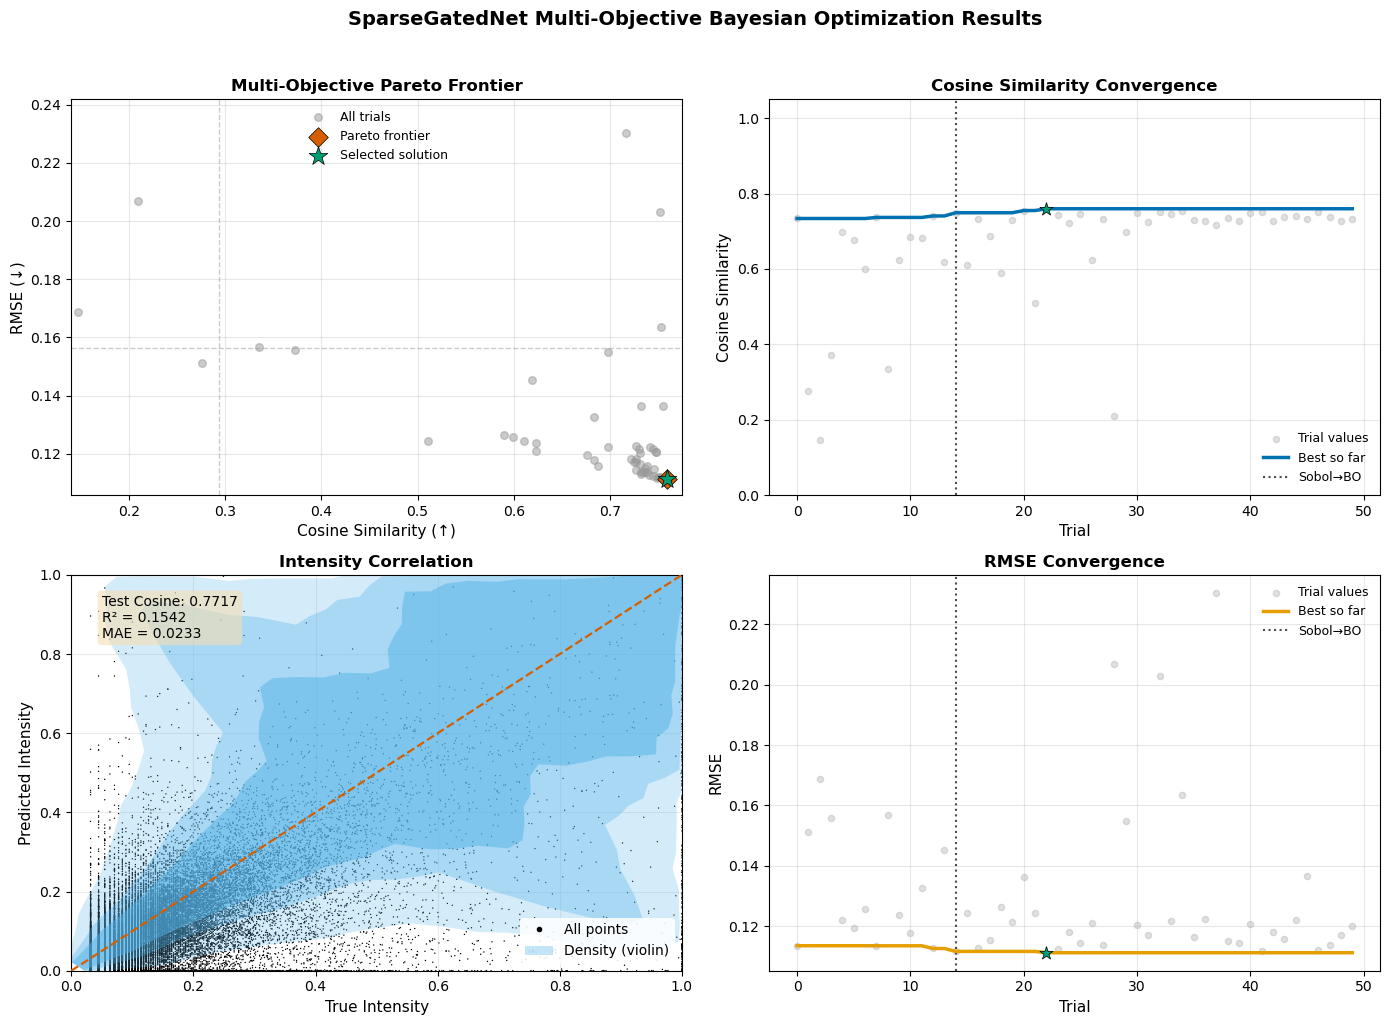

In [14]:
# ============================================================================
# OPTIMIZATION RESULTS VISUALIZATION - STANDARD 2x2 SUITE
# ============================================================================

# Colorblind-friendly Okabe–Ito palette (from standard plots)
PALETTE = {
    "blue": "#0072B2",
    "sky": "#56B4E9",
    "orange": "#E69F00",
    "vermillion": "#D55E00",
    "yellow": "#F0E442",
    "green": "#009E73",
    "purple": "#CC79A7",
    "black": "#000000",
    "grey": "#999999",
}

# Set white background style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ---------- Top-Left: Pareto Frontier ----------
ax = axes[0, 0]
ax.scatter(df_trials['cosine_similarity'], df_trials['rmse'], 
          alpha=0.5, color=PALETTE["grey"], s=30, label='All trials')
if len(pareto_trials) > 0:
    ax.scatter(pareto_trials['cosine_similarity'], pareto_trials['rmse'], 
              color=PALETTE["vermillion"], s=100, marker='D', 
              edgecolor=PALETTE["black"], linewidth=0.5, label='Pareto frontier')
ax.scatter(best_trial['cosine_similarity'], best_trial['rmse'], 
          color=PALETTE["green"], s=200, marker='*', 
          edgecolor=PALETTE["black"], linewidth=0.5, label='Selected solution')
ax.axvline(cos_threshold, color=PALETTE["grey"], linestyle='--', alpha=0.5, linewidth=1)
ax.axhline(rmse_threshold, color=PALETTE["grey"], linestyle='--', alpha=0.5, linewidth=1)
ax.set_xlabel('Cosine Similarity (↑)', fontsize=11)
ax.set_ylabel('RMSE (↓)', fontsize=11)
ax.set_title('Multi-Objective Pareto Frontier', fontsize=12, fontweight='bold')
ax.legend(frameon=False, fontsize=9, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim([df_trials['cosine_similarity'].min() * 0.95, 
             df_trials['cosine_similarity'].max() * 1.02])
ax.set_ylim([df_trials['rmse'].min() * 0.95, 
             df_trials['rmse'].max() * 1.05])

# ---------- Top-Right: Cosine Similarity Convergence ----------
ax = axes[0, 1]
cosine_history = df_trials['cosine_similarity'].values
best_cosine_history = np.maximum.accumulate(cosine_history)

# Plot trial values as scatter
ax.scatter(range(len(cosine_history)), cosine_history, 
          alpha=0.3, s=20, color=PALETTE["grey"], label='Trial values')
# Plot best so far as line
ax.plot(best_cosine_history, color=PALETTE["blue"], linewidth=2.5, 
        label='Best so far', zorder=5)
# Mark transition from Sobol to BO
ax.axvline(config.n_initial_points, color=PALETTE["black"], 
          linestyle=':', linewidth=1.5, alpha=0.7, label='Sobol→BO')
# Highlight best point
best_idx = np.argmax(cosine_history)
ax.scatter(best_idx, cosine_history[best_idx], color=PALETTE["green"], 
          s=100, marker='*', zorder=10, edgecolor=PALETTE["black"], linewidth=0.5)

ax.set_xlabel('Trial', fontsize=11)
ax.set_ylabel('Cosine Similarity', fontsize=11)
ax.set_title('Cosine Similarity Convergence', fontsize=12, fontweight='bold')
ax.legend(frameon=False, fontsize=9, loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.05])

# ---------- Bottom-Left: Intensity Correlation (Standard Style) ----------
ax = axes[1, 0]

# Prepare data for intensity correlation plot
y_true_flat = np.ravel(data['y_test']).astype(float)
y_pred_flat = np.ravel(y_test_pred).astype(float)
m = np.isfinite(y_true_flat) & np.isfinite(y_pred_flat)
x = y_true_flat[m]
y = y_pred_flat[m]

# Rotate to (u,v) coordinates for violin visualization
root2 = np.sqrt(2.0)
u = (x + y) / root2
v = (y - x) / root2

# Bin along diagonal and compute quantiles
n_bins = 60
u_edges = np.linspace(u.min(), u.max(), n_bins + 1)
u_centers = 0.5 * (u_edges[:-1] + u_edges[1:])
widths_90 = np.full(n_bins, np.nan)
widths_75 = np.full(n_bins, np.nan)
widths_60 = np.full(n_bins, np.nan)
min_count = 10

for i in range(n_bins):
    mask = (u >= u_edges[i]) & (u < u_edges[i+1])
    if np.count_nonzero(mask) >= min_count:
        abs_v = np.abs(v[mask])
        widths_60[i] = np.percentile(abs_v, 60)
        widths_75[i] = np.percentile(abs_v, 75)
        widths_90[i] = np.percentile(abs_v, 90)

# Interpolate and smooth
def _interp_nan(a):
    xidx = np.arange(a.size)
    msk = ~np.isnan(a)
    if msk.sum() < 2:
        return np.nan_to_num(a, nan=0.0)
    return np.interp(xidx, xidx[msk], a[msk])

def _smooth(a, k=5):
    if k <= 1: return a
    kernel = np.ones(k) / k
    return np.convolve(a, kernel, mode='same')

widths_60 = _smooth(_interp_nan(widths_60), 5)
widths_75 = _smooth(_interp_nan(widths_75), 5)
widths_90 = _smooth(_interp_nan(widths_90), 5)

def band_polygon(u_vals, w_vals):
    x_upper = (u_vals - w_vals) / root2
    y_upper = (u_vals + w_vals) / root2
    x_lower = (u_vals + w_vals) / root2
    y_lower = (u_vals - w_vals) / root2
    x_poly = np.r_[x_upper, x_lower[::-1]]
    y_poly = np.r_[y_upper, y_lower[::-1]]
    return x_poly, y_poly

# Scatter points
ax.scatter(x, y, s=4, marker='.', color=PALETTE["black"],
           edgecolors='none', alpha=1.0, zorder=0, rasterized=True)

# Draw violin bands
for w, a in [(widths_90, 0.25), (widths_75, 0.35), (widths_60, 0.5)]:
    xp, yp = band_polygon(u_centers, w)
    ax.fill(xp, yp, color=PALETTE["sky"], alpha=a, edgecolor='none', zorder=2)

# Perfect prediction line
max_val = 1.0  # Clip to 1 as standard
ax.plot([0, max_val], [0, max_val], color=PALETTE["vermillion"],
        linestyle='--', linewidth=1.6, label='Perfect Prediction', zorder=4)

ax.set_xlim(0, max_val)
ax.set_ylim(0, max_val)
ax.set_xlabel('True Intensity', fontsize=11)
ax.set_ylabel('Predicted Intensity', fontsize=11)
ax.set_title('Intensity Correlation', fontsize=12, fontweight='bold')

# Legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
violin_handle = Patch(facecolor=PALETTE["sky"], alpha=0.35, edgecolor='none', label='Density (violin)')
points_handle = Line2D([0], [0], linestyle='none', marker='.', markersize=6,
                       color=PALETTE["black"], label='All points')
ax.legend(handles=[points_handle, violin_handle], loc='lower right',
          frameon=True, facecolor='white', framealpha=0.85, edgecolor='none')
ax.grid(alpha=0.25)

# Metrics annotation
test_cosine = test_metrics['cosine_similarity']
test_r2 = test_metrics['r2']
test_mae = test_metrics['mae']
text = f"Test Cosine: {test_cosine:.4f}\nR² = {test_r2:.4f}\nMAE = {test_mae:.4f}"
ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=10,
        va='top', bbox=dict(boxstyle='round', facecolor='wheat',
        alpha=0.6, edgecolor='none'), zorder=5)

# ---------- Bottom-Right: RMSE Convergence ----------
ax = axes[1, 1]
rmse_history = df_trials['rmse'].values
best_rmse_history = np.minimum.accumulate(rmse_history)

# Plot trial values as scatter
ax.scatter(range(len(rmse_history)), rmse_history, 
          alpha=0.3, s=20, color=PALETTE["grey"], label='Trial values')
# Plot best so far as line
ax.plot(best_rmse_history, color=PALETTE["orange"], linewidth=2.5, 
        label='Best so far', zorder=5)
# Mark transition
ax.axvline(config.n_initial_points, color=PALETTE["black"], 
          linestyle=':', linewidth=1.5, alpha=0.7, label='Sobol→BO')
# Highlight best point
best_idx = np.argmin(rmse_history)
ax.scatter(best_idx, rmse_history[best_idx], color=PALETTE["green"], 
          s=100, marker='*', zorder=10, edgecolor=PALETTE["black"], linewidth=0.5)

ax.set_xlabel('Trial', fontsize=11)
ax.set_ylabel('RMSE', fontsize=11)
ax.set_title('RMSE Convergence', fontsize=12, fontweight='bold')
ax.legend(frameon=False, fontsize=9, loc='upper right')
ax.grid(True, alpha=0.3)

# Overall title
plt.suptitle('SparseGatedNet Multi-Objective Bayesian Optimization Results', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig(config.models_dir / 'sparsegatednet_optimization_results.png', 
            dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

## 15. Save Results

Save the optimized model and results for future use.

In [15]:
# Prepare results dictionary
optimization_results = {
    'best_parameters': best_params,
    'best_validation_metrics': {
        'cosine_similarity': best_trial['cosine_similarity'],
        'rmse': best_trial['rmse']
    },
    'test_metrics': test_metrics,
    'pareto_frontier': pareto_trials.to_dict('records') if len(pareto_trials) > 0 else [],
    'all_trials': df_trials.to_dict('records'),
    'optimization_time': optimization_time,
    'training_time': train_time,
    'objective_thresholds': {
        'cosine_similarity': cos_threshold,
        'rmse': rmse_threshold
    },
    'config': vars(config),
    'model_stats': {
        'total_params': total_params,
        'trainable_params': trainable_params
    }
}

# Save model and results
model_path = config.models_dir / 'optimized_sparsegatednet_model.pth'
torch.save({
    'model_state_dict': final_model.state_dict(),
    'model_config': final_config,
    'best_parameters': best_params,
    'scaler': data['final_scaler'],
    'test_metrics': test_metrics
}, model_path)
logger.info(f"Model saved to {model_path}")

# Save optimization results
results_path = config.models_dir / 'optimization_results.pkl'
with open(results_path, 'wb') as f:
    pickle.dump(optimization_results, f)
logger.info(f"Results saved to {results_path}")

# Save results as JSON for portability
json_path = config.models_dir / 'optimization_results.json'
with open(json_path, 'w') as f:
    json.dump(optimization_results, f, indent=2, default=str)
logger.info(f"Results saved to {json_path}")

# Generate summary report
report_path = config.models_dir / 'optimization_report.txt'
with open(report_path, 'w') as f:
    f.write("SPARSEGATEDNET MULTI-OBJECTIVE BAYESIAN OPTIMIZATION REPORT\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("OPTIMIZATION CONFIGURATION\n")
    f.write("-" * 30 + "\n")
    f.write(f"Total trials: {config.n_iterations}\n")
    f.write(f"Initial points (Sobol): {config.n_initial_points}\n")
    f.write(f"Batch size: {config.batch_size}\n")
    f.write(f"Parallel workers: {min(config.batch_size, os.cpu_count())}\n")
    f.write(f"Subsample fraction: {config.row_subsample_frac}\n")
    f.write(f"Max bins for eval: {config.max_bins_eval}\n")
    f.write(f"Optimization time: {optimization_time:.1f}s\n\n")
    
    f.write("OBJECTIVE THRESHOLDS\n")
    f.write("-" * 30 + "\n")
    f.write(f"Cosine similarity >= {cos_threshold:.4f}\n")
    f.write(f"RMSE <= {rmse_threshold:.4f}\n\n")
    
    f.write("BEST HYPERPARAMETERS\n")
    f.write("-" * 30 + "\n")
    for param, value in best_params.items():
        f.write(f"{param:<25}: {value}\n")
    
    f.write("\nPERFORMANCE METRICS\n")
    f.write("-" * 30 + "\n")
    f.write(f"Validation Cosine (subsample): {best_trial['cosine_similarity']:.6f}\n")
    f.write(f"Validation RMSE (subsample): {best_trial['rmse']:.6f}\n")
    f.write(f"Validation Cosine (full): {full_eval['cosine_similarity'][0]:.6f}\n")
    f.write(f"Validation RMSE (full): {full_eval['rmse'][0]:.6f}\n")
    f.write(f"Test Cosine: {test_metrics['cosine_similarity']:.6f}\n")
    f.write(f"Test RMSE: {test_metrics['rmse']:.6f}\n")
    f.write(f"Test MAE: {test_metrics['mae']:.6f}\n")
    f.write(f"Test R²: {test_metrics['r2']:.6f}\n")
    
    f.write("\nMODEL ARCHITECTURE\n")
    f.write("-" * 30 + "\n")
    f.write(f"Total parameters: {total_params:,}\n")
    f.write(f"Trainable parameters: {trainable_params:,}\n")
    f.write(f"Gated layers: {best_params['num_layers']}\n")
    f.write(f"Hidden size: {best_params['hidden_size']}\n")
    f.write(f"Gate hidden: {best_params['gate_hidden']}\n")
    
    f.write("\nPARETO FRONTIER\n")
    f.write("-" * 30 + "\n")
    f.write(f"Number of Pareto-optimal solutions: {len(pareto_trials)}\n")
    if len(pareto_trials) > 0:
        f.write(f"Cosine range: [{pareto_trials['cosine_similarity'].min():.4f}, "
               f"{pareto_trials['cosine_similarity'].max():.4f}]\n")
        f.write(f"RMSE range: [{pareto_trials['rmse'].min():.4f}, "
               f"{pareto_trials['rmse'].max():.4f}]\n")

logger.info(f"Report saved to {report_path}")

print("\n" + "=" * 60)
print("OPTIMIZATION COMPLETE")
print("=" * 60)
print(f"Optimization time: {optimization_time:.1f}s ({optimization_time/60:.1f} minutes)")
print(f"Training time: {train_time:.1f}s")
print(f"\nBest validation performance:")
print(f"  Cosine Similarity: {best_trial['cosine_similarity']:.6f}")
print(f"  RMSE: {best_trial['rmse']:.6f}")
print(f"\nTest set performance:")
print(f"  Cosine Similarity: {test_metrics['cosine_similarity']:.6f}")
print(f"  RMSE: {test_metrics['rmse']:.6f}")
print(f"\nPareto frontier contains {len(pareto_trials)} solutions")
print(f"All results saved to {config.models_dir}")

2025-08-25 17:48:48,473 - INFO - Model saved to ../models/bayesian_sparse_gated/optimized_sparsegatednet_model.pth
2025-08-25 17:48:48,508 - INFO - Results saved to ../models/bayesian_sparse_gated/optimization_results.pkl
2025-08-25 17:48:48,567 - INFO - Results saved to ../models/bayesian_sparse_gated/optimization_results.json
2025-08-25 17:48:48,577 - INFO - Report saved to ../models/bayesian_sparse_gated/optimization_report.txt



OPTIMIZATION COMPLETE
Optimization time: 2101.5s (35.0 minutes)
Training time: 765.6s

Best validation performance:
  Cosine Similarity: 0.759793
  RMSE: 0.111280

Test set performance:
  Cosine Similarity: 0.771718
  RMSE: 0.070232

Pareto frontier contains 1 solutions
All results saved to ../models/bayesian_sparse_gated
